Instanciando la red pre-entrenada VGG16 y configurando la entrada para imágenes RGB 180x180

Sin expansión de datos y con la BD de perros y gatos reducida (sólo 5000 imágenes)

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

Visualizando la arquitectura de la red

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Accediendo a la BD de perros y gatos



In [6]:
!pip install gdown #Instala una librería para descargar archivos de Google Drive
!gdown --id 1YeHqH7Gbypust6sZT2ehl8CUE9ELHQYC #Descarga el dataset que está en el Drive del Prof. Pereira
!unzip cats_vs_dogs_small.zip #Descomprime el archivo del dataset
from IPython.display import Image #Librería para visualizar imágenes en Jupyter
Image(filename='cats_vs_dogs_small/validation/cat/1488.jpg') #Visualiza el gato 1488
!cp cats_vs_dogs_small/train/Cat/665.jpg cats_vs_dogs_small/train/Cat/666.jpg
!cp cats_vs_dogs_small/train/Cat/834.jpg cats_vs_dogs_small/train/Cat/835.jpg

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: cats_vs_dogs_small/test/cat/1507.jpg  
  inflating: cats_vs_dogs_small/test/cat/1508.jpg  
  inflating: cats_vs_dogs_small/test/cat/1509.jpg  
  inflating: cats_vs_dogs_small/test/cat/1510.jpg  
  inflating: cats_vs_dogs_small/test/cat/1511.jpg  
  inflating: cats_vs_dogs_small/test/cat/1512.jpg  
  inflating: cats_vs_dogs_small/test/cat/1513.jpg  
  inflating: cats_vs_dogs_small/test/cat/1514.jpg  
  inflating: cats_vs_dogs_small/test/cat/1515.jpg  
  inflating: cats_vs_dogs_small/test/cat/1516.jpg  
  inflating: cats_vs_dogs_small/test/cat/1517.jpg  
  inflating: cats_vs_dogs_small/test/cat/1518.jpg  
  inflating: cats_vs_dogs_small/test/cat/1519.jpg  
  inflating: cats_vs_dogs_small/test/cat/1520.jpg  
  inflating: cats_vs_dogs_small/test/cat/1521.jpg  
  inflating: cats_vs_dogs_small/test/cat/1522.jpg  
  inflating: cats_vs_dogs_small/test/cat/1523.jpg  
  inflating: cats_vs_dogs_small/test/cat/1524.jpg  
  i

In [7]:
new_base_dir=r"cats_vs_dogs_small"

Ajustando los datos de la BD de perros y gatos

In [8]:
"""
import os, shutil
def make_subset(subset_name, start_index, end_index):
    for category in ("Cat", "Dog"):
        dir = new_base_dir+"/"+subset_name+"/"+category
        fnames = [f"{original_dir}/{category}/{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            print(fname)
            print(dir)
            shutil.copy(fname,dir)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)
"""

'\nimport os, shutil\ndef make_subset(subset_name, start_index, end_index):\n    for category in ("Cat", "Dog"):\n        dir = new_base_dir+"/"+subset_name+"/"+category\n        fnames = [f"{original_dir}/{category}/{i}.jpg" for i in range(start_index, end_index)]\n        for fname in fnames:\n            print(fname)\n            print(dir)\n            shutil.copy(fname,dir)\n\nmake_subset("train", start_index=0, end_index=1000)\nmake_subset("validation", start_index=1000, end_index=1500)\nmake_subset("test", start_index=1500, end_index=2500)\n'

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Extrayendo las características de los conjuntos de entrenamiento, validación y prueba con sus etiquetas

In [10]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
#test_features, test_labels =  get_features_and_labels(test_dataset)

In [11]:
train_features.shape

(2000, 5, 5, 512)

Definiendo la arquitectura de la red e hiperparámetros de pérdida, algoritmo de descenso de gradiente y métrica de evaluación

In [12]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Entrenando ...

In [13]:
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels))

Epoch 1/50
63/63 [==============================] - 1s 8ms/step - loss: 16.4317 - accuracy: 0.9290 - val_loss: 7.0102 - val_accuracy: 0.9540
Epoch 2/50
63/63 [==============================] - 0s 5ms/step - loss: 4.2365 - accuracy: 0.9690 - val_loss: 11.1931 - val_accuracy: 0.9420
Epoch 3/50
63/63 [==============================] - 0s 6ms/step - loss: 2.1115 - accuracy: 0.9860 - val_loss: 8.1974 - val_accuracy: 0.9530
Epoch 4/50
63/63 [==============================] - 0s 6ms/step - loss: 0.9746 - accuracy: 0.9935 - val_loss: 15.8465 - val_accuracy: 0.9300
Epoch 5/50
63/63 [==============================] - 0s 7ms/step - loss: 1.0004 - accuracy: 0.9910 - val_loss: 5.2092 - val_accuracy: 0.9720
Epoch 6/50
63/63 [==============================] - 0s 6ms/step - loss: 0.5765 - accuracy: 0.9945 - val_loss: 5.1213 - val_accuracy: 0.9740
Epoch 7/50
63/63 [==============================] - 0s 7ms/step - loss: 0.9419 - accuracy: 0.9940 - val_loss: 4.3079 - val_accuracy: 0.9750
Epoch 8/50
63/63 

Visualizando la pérdida y el accuracy durante el entrenamiento

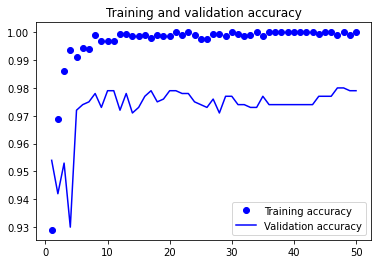

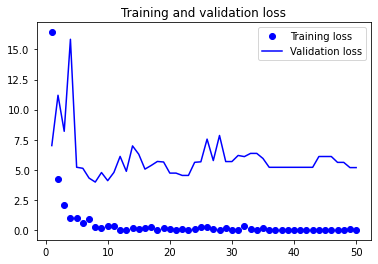

In [14]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Ejercicio:
---------
1. Hay aún overfitting ... Intente alguna de las estrategias que ya conoce para reducirlo
2. ¿Qué efecto tiene cambiar la cantidad de épocas?